# Метод опорных векторов (Support Vector Machine)

In [1]:
import time
import re
from __future__ import print_function
from collections import defaultdict

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_union, make_pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler, LabelEncoder, MinMaxScaler, LabelBinarizer, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

import xgboost as xgb
import lightgbm as lgb

%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 8)
pd.options.display.float_format = '{:.2f}'.format

In [2]:
from sklearn.datasets import make_blobs, make_classification

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

def plot_svc_log_decision_function(clf1, clf2, ax=None):
    if ax is None:
        ax = plt.gca()# get current axis (получить текущие оси)
    x = np.linspace(plt.xlim()[0], plt.xlim()[1], 30)
    y = np.linspace(plt.ylim()[0], plt.ylim()[1], 30)
    XX, YY = np.meshgrid(x, y)
    XY = np.c_[XX.ravel(), YY.ravel()]
    P1 = clf1.decision_function(XY)
    P1 = P1.reshape(XX.shape)
    
    P2 = clf2.decision_function(XY)
    P2 = P2.reshape(XX.shape)
    
    cplot = ax.contour(XX, YY, P1, colors='k', label='svm',
                      levels=[-1, 0, 1], alpha=0.5,
                      linestyles=['--', '-', '--'])
    ax.clabel(cplot, inline=1, fontsize=10)
    
    ax.contour(XX, YY, P2, colors='r', label='logreg',
               levels=[0], alpha=0.5,
               linestyles='-')
    
def plot_svc_decision_function(clf1, ax=None):
    if ax is None:
        ax = plt.gca()# get current axis (получить текущие оси)
    x = np.linspace(plt.xlim()[0], plt.xlim()[1], 30)
    y = np.linspace(plt.ylim()[0], plt.ylim()[1], 30)
    XX, YY = np.meshgrid(x, y)
    XY = np.c_[XX.ravel(), YY.ravel()]
    P1 = clf1.decision_function(XY)
    P1 = P1.reshape(XX.shape)
    
      
    cplot = ax.contour(XX, YY, P1, colors='k', label='svm',
                      levels=[-1, 0, 1], alpha=0.5,
                      linestyles=['--', '-', '--'])
    ax.clabel(cplot, inline=1, fontsize=10)

def lin_sep_svm_demo(class_sep=2):
    X, y = make_classification(n_samples=100, n_features=2, n_informative=2, class_sep=class_sep, scale=1,
                              n_redundant=0, n_clusters_per_class=1, random_state=31)
    lin_svm = SVC(kernel='linear', C=100).fit(X, y)
    
    log_reg = LogisticRegression(C=100).fit(X, y)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(X[:, 0], X[:, 1], c=y, s=70, cmap='summer')
    plot_svc_log_decision_function(lin_svm, log_reg)
    
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    
    plt.xlim(-2, 5)
    plt.ylim(-3, 4)

<ipython-input-2-b7bd7701dc5f>:19: UserWarning: The following kwargs were not used by contour: 'label'
  cplot = ax.contour(XX, YY, P1, colors='k', label='svm',
<ipython-input-2-b7bd7701dc5f>:24: UserWarning: The following kwargs were not used by contour: 'label'
  ax.contour(XX, YY, P2, colors='r', label='logreg',


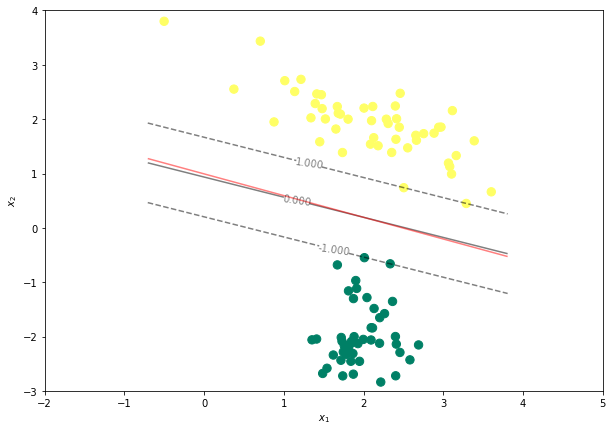

In [3]:
lin_sep_svm_demo(2)

### Неразделимый случай 

Будем допускать пропуск объектов за разделительную линию
* Вместо условия $y^{(i)}(\langle w, x^{(i)} \rangle + w_0 ) \geq 1$
* Будет условие $y^{(i)}(\langle w, x^{(i)} \rangle + w_0 ) \geq 1 - \xi_i, \quad \xi_i \geq 0$

![slack.png](attachment:slack.png)

А целевой функционал заменим на 

$ \frac{1}{2} ||w||^2 + C\sum\limits_i\xi_i  \rightarrow \min\limits_{w,w_0,\xi}  $

# Ядра и спрямляющие пространства

In [4]:
from sklearn.datasets import make_circles
from mpl_toolkits import mplot3d

def demo_nonlin_data():
    X, y = make_circles(n_samples=100, factor=0.1,
                        noise=0.1, random_state=0)
    fig = plt.figure()
    ax = fig.add_subplot(1, 2, 1)
    
    ax.scatter(X[:, 0], X[:, 1], c=y, s=70, cmap='summer')
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    
    r = X[:, 0] ** 2 + X[:, 1] ** 2
    ax = fig.add_subplot(1, 2, 2)
    
    ax = fig.add_subplot(1, 2, 2, projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=70, cmap='summer')
    ax.view_init(elev=30, azim=30)
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_zlabel('$x_1^2 + x_2^2$')

<ipython-input-4-ec69532f5604>:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(1, 2, 2, projection='3d')


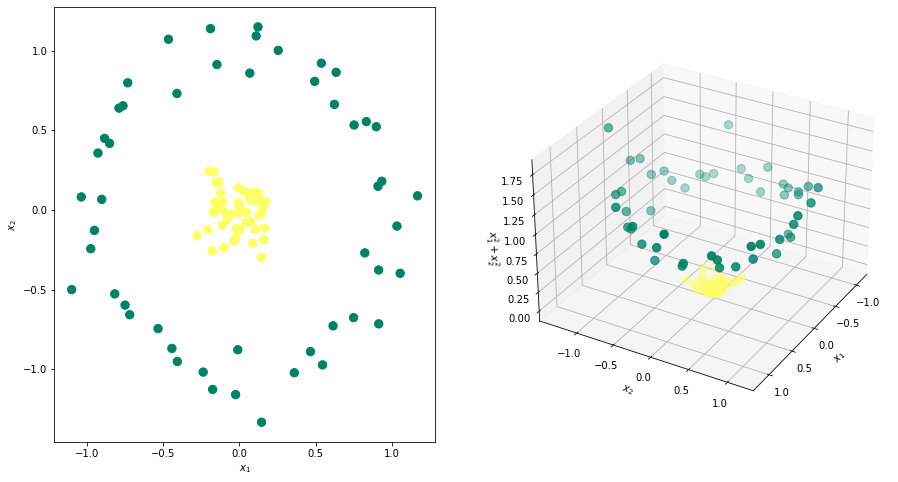

In [5]:
demo_nonlin_data()

In [6]:
 def lin_sep_svm_demo_kernel_C(class_sep=2, kernel='linear', C=1, gamma=1.2, degree=2, coef0=0.0):
        X, y = make_classification(n_samples=100, n_features=2, n_informative=2, class_sep=class_sep, scale=1,
                                  n_redundant=0, n_clusters_per_class=1, random_state=31)
        lin_svm = SVC(kernel=kernel, C=C, gamma=gamma, degree=degree, coef0=0.0).fit(X, y)
        
        plt.figure(figsize=(10, 7))
        plt.scatter(X[:, 0], X[:, 1], c=y, s=70, cmap='summer')
        plot_svc_decision_function(lin_svm)
        plt.scatter(lin_svm.support_vectors_[:, 0], lin_svm.support_vectors_[:, 1],
                   s=200, facecolors='none')
        
        plt.xlabel('$x_1$')
        plt.ylabel('$x_2$')
        
        plt.xlim(-2, 5)
        plt.ylim(-3, 4)

In [7]:
from IPython.display import YouTubeVideo

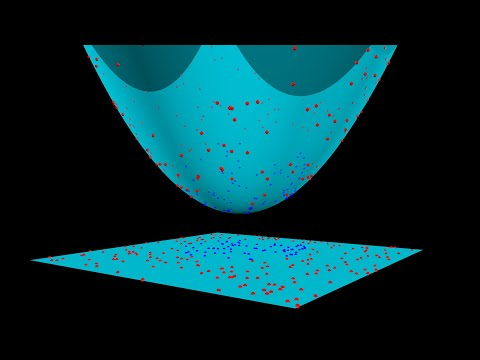

In [8]:
YouTubeVideo('3liCbRZPrZA', width=640, height=480)

<ipython-input-2-b7bd7701dc5f>:39: UserWarning: The following kwargs were not used by contour: 'label'
  cplot = ax.contour(XX, YY, P1, colors='k', label='svm',


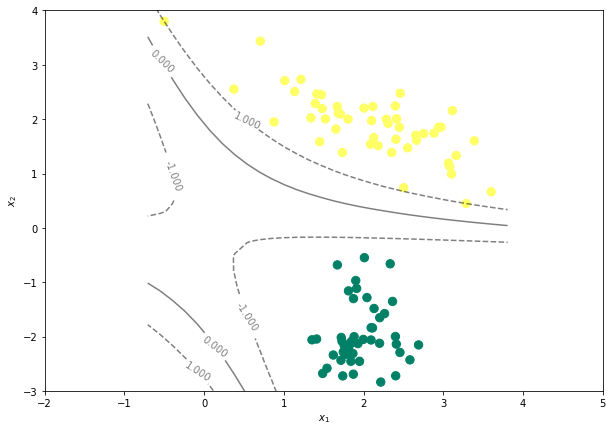

In [9]:
lin_sep_svm_demo_kernel_C(kernel=['rbf', 'linear', 'poly'][2])

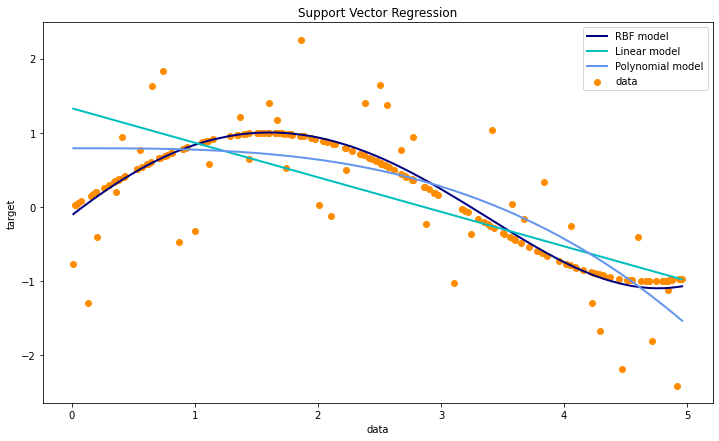

In [10]:
from sklearn.svm import SVR

X = np.sort(5 * np.random.rand(200, 1), axis=0)
y = np.sin(X).ravel()
y[::5] += 3 * (0.5 - np.random.rand(40))

svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
svr_lin = SVR(kernel='linear', C=1e3)
svr_poly = SVR(kernel='poly', C=1e3, degree=3)

y_rbf = svr_rbf.fit(X, y).predict(X)
y_lin = svr_lin.fit(X, y).predict(X)
y_poly = svr_poly.fit(X, y).predict(X)

lw = 2
plt.figure(figsize=(12, 7))
plt.scatter(X, y, color='darkorange', label='data')
plt.plot(X, y_rbf, color='navy', lw=lw, label='RBF model')
plt.plot(X, y_lin, color='c', lw=lw, label='Linear model')
plt.plot(X, y_poly, color='cornflowerblue', lw=lw, label='Polynomial model')

plt.xlabel('data')
plt.ylabel('target')
plt.title('Support Vector Regression')

plt.legend()
plt.show()

# Titanic

In [11]:
df_train = pd.read_csv('datasets/train.csv')
df_train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.00,1,0,A/5 21171,7.25,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.00,1,0,PC 17599,71.28,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.00,0,0,STON/O2. 3101282,7.92,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00,1,0,113803,53.10,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.00,0,0,373450,8.05,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.46,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.00,0,0,17463,51.86,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.00,3,1,349909,21.07,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.00,0,2,347742,11.13,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.00,1,0,237736,30.07,NaN,C


In [12]:
df_test = pd.read_csv('datasets/test.csv')
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.50,0,0,330911,7.83,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.00,1,0,363272,7.00,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.00,0,0,240276,9.69,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.00,0,0,315154,8.66,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.00,1,1,3101298,12.29,NaN,S


In [13]:
survived = df_train['Survived']
df_train.drop(labels=['Survived'], axis=1, inplace=True)
df_train['Survived'] = survived
df_train.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,1,3,"Braund, Mr. Owen Harris",male,22.00,1,0,A/5 21171,7.25,NaN,S,0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.00,1,0,PC 17599,71.28,C85,C,1
2,3,3,"Heikkinen, Miss. Laina",female,26.00,0,0,STON/O2. 3101282,7.92,NaN,S,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00,1,0,113803,53.10,C123,S,1
4,5,3,"Allen, Mr. William Henry",male,35.00,0,0,373450,8.05,NaN,S,0


In [14]:
class LabelEncoderPipelineFriendly(LabelEncoder):
    
    def fit(self, X, y=None):
        super(LabelEncoderPipelineFriendly, self).fit(X)
        
    def transform(self, X, y=None):
        return super(LabelEncoderPipelineFriendly, self).transform(X).reshape(-1, 1)
    
    def fit_transform(self, X, y=None):
        return super(LabelEncoderPipelineFriendly, self).fit(X).transform(X).reshape(-1, 1)

class FeatureSum(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return np.sum(X, axis=1).reshape(-1, 1)
    
    def fit_transform(self, X, y=None):
        return self.fit(X).transform(X)

class AgeFeature(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X['Initial'] = 0
        for i in X:
            X['Initial'] = X.Name.str.extract('([A-Za-z]+)\.')  # lests extract the Salutation
        
        X['Initial'].replace(
            ['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don'],
            ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr'],
            inplace=True
        )
        X.groupby('Initial')['Age'].mean()
        
        X.loc[(X.Age.isnull()) & (X.Initial=='Mr'), 'Age'] = 33
        X.loc[(X.Age.isnull()) & (X.Initial=='Mrs'), 'Age'] = 36
        X.loc[(X.Age.isnull()) & (X.Initial=='Master'), 'Age'] = 5
        X.loc[(X.Age.isnull()) & (X.Initial=='Miss'), 'Age'] = 22
        X.loc[(X.Age.isnull()) & (X.Initial=='Other'), 'Age'] = 46
        return X['Age'].values.reshape(-1, 1)
    
    def fit_transform(self, X, y=None):
        return self.fit(X).transform(X)

In [15]:
from sklearn.preprocessing import MinMaxScaler

def get_sex_col(df):
    return df[['Sex']]

def get_age_name_cols(df):
    return df[['Age', 'Name']]

def get_pclass_col(df):
    return df[['Pclass']]

def get_sum_cols(df):
    return df[['Age', 'Fare']]

def get_num_cols(df):
    return df[['Fare', 'SibSp', 'Parch']]

vec = make_union(*[
    make_pipeline(FunctionTransformer(get_pclass_col, validate=False), OneHotEncoder(sparse=False), MinMaxScaler()),
    make_pipeline(FunctionTransformer(get_sex_col, validate=False), LabelEncoderPipelineFriendly(), MinMaxScaler()),
    make_pipeline(FunctionTransformer(get_num_cols, validate=False), SimpleImputer(strategy='mean'), MinMaxScaler()),
    make_pipeline(FunctionTransformer(get_age_name_cols, validate=False), AgeFeature(), MinMaxScaler()),
])

In [16]:
X_train = vec.fit_transform(df_train)
X_train.shape

C:\Users\adwiz\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
<ipython-input-14-947e4455a3a9>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Initial'] = 0
<ipython-input-14-947e4455a3a9>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Initial'] = X.Name.str.extract('([A-Za-z]+)\.')  # lests extract the 

(891, 8)

In [17]:
y_train = df_train['Survived']
y_train.shape

(891,)

In [25]:
svr = GridSearchCV(SVR(kernel='rbf', max_iter=100, verbose=True), cv=5,
                   param_grid={"C": [1e0, 1e1, 1e2, 1e3],
                               "gamma": np.logspace(-2, 2, 5)})

In [19]:
svr.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'C': [1.0, 10.0, 100.0, 1000.0],
                         'gamma': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])})

In [20]:
lr = LogisticRegressionCV(cv=10)
lr.fit(X_train, y_train)
lr

LogisticRegressionCV(cv=10)

In [21]:
accuracy_score(y_train, lr.predict(X_train))

0.8002244668911336

In [22]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'max_depth': [2, 3, 4, 5],
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.025, 0.1, 0.5]
}
xgb = RandomizedSearchCV(xgb.XGBClassifier(), param_grid)

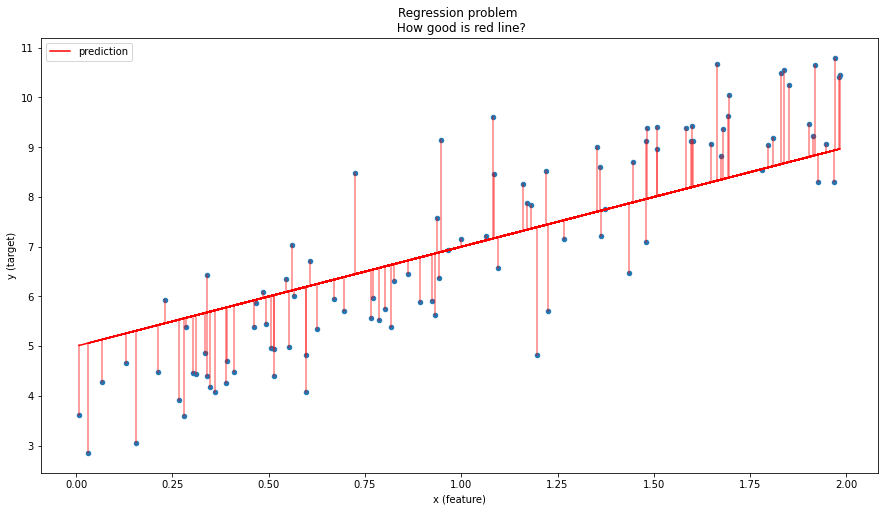

In [23]:
x = 2 * np.random.rand(100, 1)
y = 4 + 3 * x + np.random.randn(100, 1)
df = pd.DataFrame(np.hstack([x, y]), columns=['x', 'y'])

def predict(x):
    return 2 * x + 5

y_pred = predict(x)

df.plot.scatter('x', 'y')
plt.title("Regression problem \n How good is red line?")
plt.xlabel("x (feature)")
plt.ylabel("y (target)")
plt.plot(x, y_pred, color='red', label='prediction')
plt.legend()

for x_i, y_i, y_i_pred in zip(x, y, y_pred):
    plt.plot([x_i, x_i], [y_i_pred, y_i], color='red', alpha=0.5)

In [28]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
print(mean_squared_error(y, y_pred))
print(mean_absolute_error(y, y_pred))

1.4146214108947803
1.0221995752239479
